In [1]:
import os
import pandas as pd, numpy as np
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns 

from PIL import Image
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = '/kaggle/input/vinbigdata-original-image-dataset/vinbigdata/'

df_vin = pd.read_csv(PATH+'train.csv')
df_vin = df_vin.sort_values(by='image_id').reset_index(drop=True)

In [3]:
df_vin = df_vin[df_vin['class_name'].isin(['Atelectasis','Pleural effusion','Cardiomegaly'])]
df_vin['class_name'] = df_vin['class_name'].replace('Pleural effusion', 'Effusion')
df_vin = df_vin.reset_index(drop=True)
print('Shape of DataFrame: ', df_vin.shape)
print(display(df_vin))

Shape of DataFrame:  (8182, 10)


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,0007d316f756b3fa0baea2ff514ce945,Cardiomegaly,3,R10,902.0,1827.0,1829.0,2037.0,2304,2880
1,00150343289f317a0ad5629d5b7d9ef9,Effusion,10,R10,1876.0,1103.0,2239.0,1334.0,2525,2508
2,00150343289f317a0ad5629d5b7d9ef9,Effusion,10,R8,254.0,1261.0,402.0,1434.0,2525,2508
3,00150343289f317a0ad5629d5b7d9ef9,Effusion,10,R8,2054.0,1112.0,2282.0,1329.0,2525,2508
4,00150343289f317a0ad5629d5b7d9ef9,Cardiomegaly,3,R8,818.0,1053.0,1913.0,1340.0,2525,2508
...,...,...,...,...,...,...,...,...,...,...
8177,ffceb71a80efba3b83c88e11f4b9694b,Cardiomegaly,3,R11,570.0,1108.0,1973.0,2016.0,2109,2344
8178,ffceb71a80efba3b83c88e11f4b9694b,Cardiomegaly,3,R13,579.0,1074.0,1920.0,1771.0,2109,2344
8179,ffe6f9fe648a7ec29a50feb92d6c15a4,Cardiomegaly,3,R9,1144.0,1851.0,2297.0,2384.0,2685,2857
8180,ffe6f9fe648a7ec29a50feb92d6c15a4,Cardiomegaly,3,R8,1156.0,1789.0,2315.0,2360.0,2685,2857


None


In [4]:
mapping_path = {os.path.basename(x).split('.')[0]: x for x in glob('../input/*/vinbigdata/train/*.jpg')}

df_vin['path'] = df_vin['image_id'].map(mapping_path)

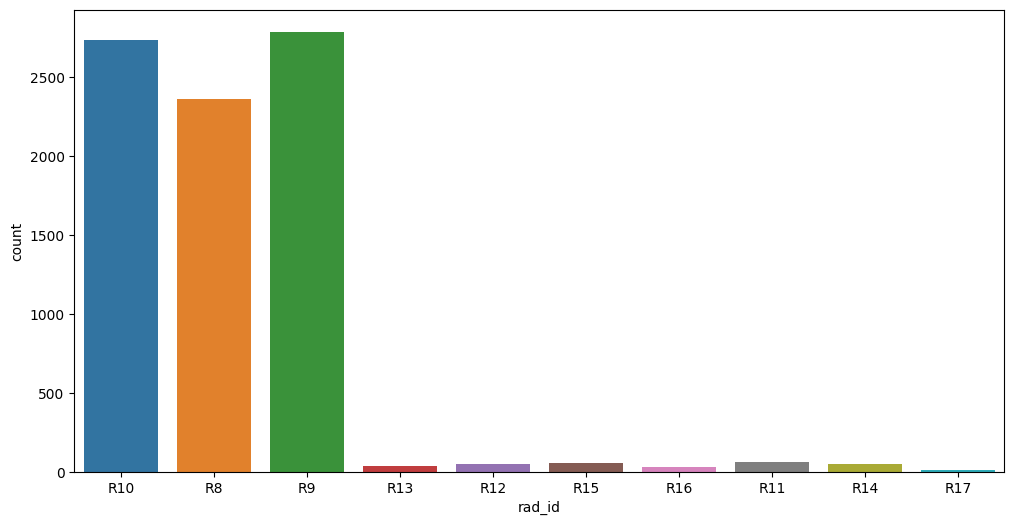

In [5]:
## There are 10 radiologist

plt.figure(figsize=(12,6))
sns.countplot(x=df_vin['rad_id'])
plt.show()

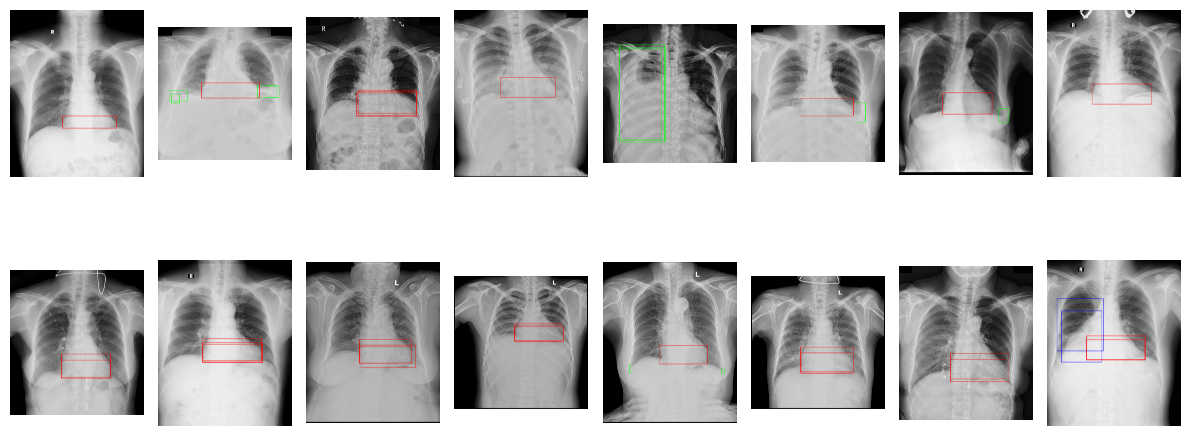

In [6]:
label2color = {
    'Cardiomegaly': (255,0,0),  # Red
    'Effusion': (0,255,0),      # Green
    'Atelectasis': (0,0,255),   # Blue
}

image_ids = df_vin['image_id'].unique()

plt.figure(figsize=(12,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    image_id = image_ids[i]
    records = df_vin[df_vin['image_id'] == image_id]
    records = records.reset_index(drop=True)
    
    path = records.iloc[0]['path']
    img = Image.open(path).convert('RGB')
    img = np.array(img)
    
    boxes = records[['x_min','y_min', 'x_max', 'y_max']].values
    boxes = boxes.astype('int64')
    labels = records['class_name'].values
    
    for box, label in zip(boxes, labels):
        color = label2color[label]
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 5)


    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Weighted Fusion Bbox(WBF)

In [7]:
!pip install -q ensemble-boxes

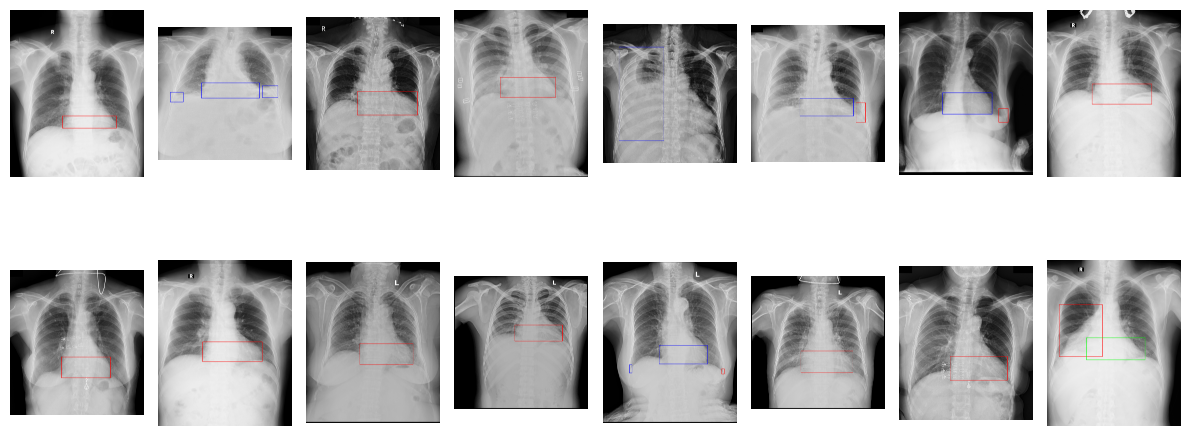

In [8]:
from ensemble_boxes import weighted_boxes_fusion


label2color = {
    3: (255, 0, 0),  # Cardiomegaly
    1 : (0, 255, 0), # Atelectacsis
    10: (0, 0, 255),  # Effusion
}

image_ids = df_vin['image_id'].unique()

plt.figure(figsize=(12, 6))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    image_id = image_ids[i]
    records = df_vin[df_vin['image_id'] == image_id]
    records = records.reset_index(drop=True)
    
    path = records.iloc[0]['path']
    img = Image.open(path).convert('RGB')
    img = np.array(img)
    
    boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
    labels = records['class_id'].values
    scores = np.ones_like(labels)  # Assuming equal scores for simplicity
    
    # Normalize the boxes to [0, 1] for WBF
    height, width, _ = img.shape
    boxes[:, [0, 2]] /= width
    boxes[:, [1, 3]] /= height
    

    # Apply Weighted Box Fusion
    boxes, scores, label_indices = weighted_boxes_fusion(
        [boxes], [scores], [labels], iou_thr=0.1, skip_box_thr=0.9
    )
    
    # Denormalize the boxes back to original dimensions
    boxes[:, [0, 2]] *= width
    boxes[:, [1, 3]] *= height
    boxes = boxes.astype('int64')
    
    for box, label in zip(boxes, labels):
        color = label2color[label]
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 5)

    plt.imshow(img)
    plt.axis('off')
    
plt.tight_layout()
plt.show()